In [23]:
# importing .py files
import court_mapping as cm
import Team_classification as tc
from Ball_Possesion import BallPossessionTracker
# Importing Libraries
import cv2
import numpy as np
import supervision as sv
from sklearn.cluster import KMeans
from pathlib import Path
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import deque
import matplotlib.pyplot as plt


In [24]:
# ----------------------------
# 1) LOAD MODELS
# ----------------------------
model_players = YOLO("/users/eleves-b/2025/prakhar.tiwari/Downloads/CV Winner/Notebooks/models/Players_detection/player.pt")      # YOLO: 0=Player
model_ball_hoop = YOLO("/users/eleves-b/2025/prakhar.tiwari/Downloads/CV Winner/Notebooks/models/Ball_detection/ball_hoop.pt")    # YOLO: 0=Ball, 1=Hoop

# ----------------------------
# 2) CLASS IDS for DeepSORT
# ----------------------------
PLAYER_CLS = 0
BALL_CLS   = 1
HOOP_CLS   = 2

In [25]:
# ----------------------------
# 3) TRACKER
# ----------------------------
tracker = DeepSort(max_age=30, n_init=3)

In [26]:
video_path = "/users/eleves-b/2025/prakhar.tiwari/Downloads/CV Winner/Notebooks/source/vid9.mp4"

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError("Cannot open video")

# Read first frame to get correct size
ret, frame = cap.read()
if not ret:
    raise RuntimeError("Cannot read first frame")

h, w = frame.shape[:2]
fps = cap.get(cv2.CAP_PROP_FPS) or 30
print("Video size:", w, h, "FPS:", fps)

out = cv2.VideoWriter(
    "tracked_output.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (w, h)
)



Video size: 1920 1080 FPS: 30.0


In [27]:

device = "cuda" 
state = tc.init_team_clustering(device=device, batch_size=32)



In [28]:
STRIDE = 30          # sample every 30 frames
SHRINK_FACTOR = 0.4  # same idea as factor=0.4

HOME = Path.cwd()
SOURCE_VIDEO_DIRECTORY = HOME / "source"

# collect all video files in source/
VIDEO_EXTS = {".mp4", ".mov", ".avi", ".mkv"}
video_paths = sorted(
    [p for p in SOURCE_VIDEO_DIRECTORY.iterdir() if p.suffix.lower() in VIDEO_EXTS]
)

print("Found videos:")
for vp in video_paths:
    print(" -", vp.name)

crops = []

for video_path in video_paths:
    print(f"\nProcessing video: {video_path.name}")
    frame_generator = sv.get_video_frames_generator(
        source_path=str(video_path),
        stride=STRIDE,
    )

    for frame in frame_generator:
        H, W = frame.shape[:2]

        # YOLO detect players
        res = model_players(frame, verbose=False)[0]
        det = sv.Detections.from_ultralytics(res)

        # keep only class 0 = player
        det = det[det.class_id == 0]

        if len(det) == 0:
            continue

        # shrink boxes around their centers
        shrunk_boxes = sv.scale_boxes(xyxy=det.xyxy, factor=SHRINK_FACTOR)

        # crop images
        for box in shrunk_boxes:
            x1, y1, x2, y2 = box.astype(int)
            crop = frame[y1:y2, x1:x2]
            if crop.size == 0:
                continue
            crops.append(crop)

print("\nCollected", len(crops), "player crops total from all videos.")


Found videos:
 - boston-celtics-new-york-knicks-game-1-q1-01.54-01.48.mp4
 - boston-celtics-new-york-knicks-game-1-q1-03.16-03.11.mp4
 - boston-celtics-new-york-knicks-game-1-q1-04.28-04.20.mp4
 - boston-celtics-new-york-knicks-game-1-q1-04.44-04.39.mp4
 - boston-celtics-new-york-knicks-game-1-q1-05.13-05.09.mp4
 - boston-celtics-new-york-knicks-game-1-q1-06.00-05.54.mp4
 - boston-celtics-new-york-knicks-game-1-q1-07.41-07.34.mp4
 - boston-celtics-new-york-knicks-game-1-q2-08.09-08.03.mp4
 - boston-celtics-new-york-knicks-game-1-q2-08.43-08.38.mp4
 - vid9.mp4

Processing video: boston-celtics-new-york-knicks-game-1-q1-01.54-01.48.mp4

Processing video: boston-celtics-new-york-knicks-game-1-q1-03.16-03.11.mp4

Processing video: boston-celtics-new-york-knicks-game-1-q1-04.28-04.20.mp4

Processing video: boston-celtics-new-york-knicks-game-1-q1-04.44-04.39.mp4

Processing video: boston-celtics-new-york-knicks-game-1-q1-05.13-05.09.mp4

Processing video: boston-celtics-new-york-knicks-game

In [29]:
state = tc.train_team_clusters(crops, state)
print("Team clustering trained.")


SigLIP embeddings: 0it [00:00, ?it/s]

SigLIP embeddings: 18it [00:02,  7.35it/s]


Team clustering trained.


In [30]:
def make_horizontal_grid(images, max_n=10, target_h=160):
    """
    Stack up to max_n images horizontally, resized to same height.
    Returns a single BGR image.
    """
    if len(images) == 0:
        return None

    imgs = images[:max_n]
    resized = []
    for img in imgs:
        h, w = img.shape[:2]
        scale = target_h / h
        new_w = int(w * scale)
        img_resized = cv2.resize(img, (new_w, target_h))
        resized.append(img_resized)

    grid = np.concatenate(resized, axis=1)
    return grid


SigLIP embeddings: 0it [00:00, ?it/s]

SigLIP embeddings: 1it [00:00, 38.04it/s]


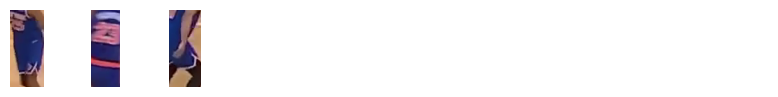

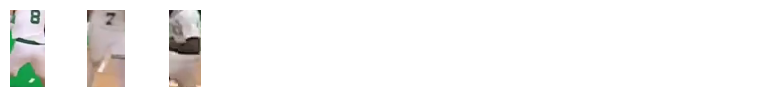

In [31]:
# Detect players in this frame
res = model_players(frame, verbose=False)[0]
det = sv.Detections.from_ultralytics(res)
det = det[det.class_id == 0]   # only class 0 = player

if len(det) == 0:
    print("No players found in this frame")
else:
    H, W = frame.shape[:2]
    shrunk_boxes = sv.scale_boxes(xyxy=det.xyxy, factor=0.4)

    crops_frame = []
    for box in shrunk_boxes:
        x1, y1, x2, y2 = box.astype(int)
        crop = frame[y1:y2, x1:x2]
        if crop.size == 0:
            continue
        crops_frame.append(crop)

    # 🔥 Call your function from Team_classification.py
    teams = tc.assign_teams_to_crops(crops_frame, state)

    team_0 = [c for c, t in zip(crops_frame, teams) if t == 0]
    team_1 = [c for c, t in zip(crops_frame, teams) if t == 1]

    sv.plot_images_grid(images=team_0[:10], grid_size=(1, 10), size=(10, 1))
    sv.plot_images_grid(images=team_1[:10], grid_size=(1, 10), size=(10, 1))


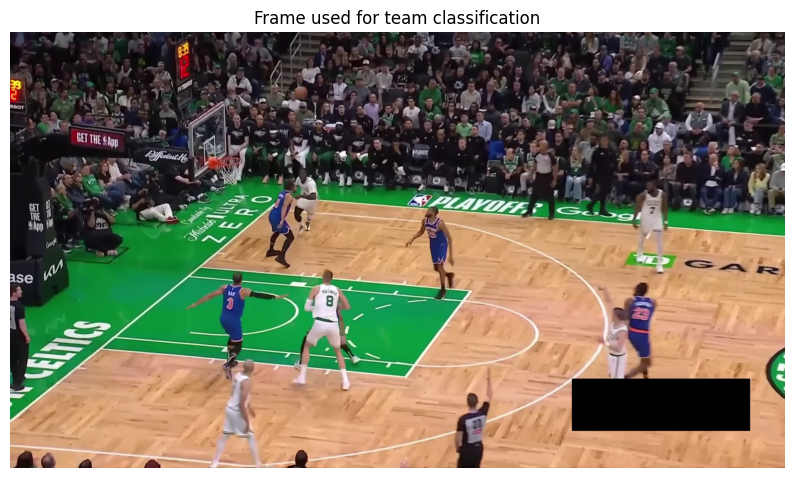

In [32]:

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # BGR → RGB
plt.axis("off")
plt.title("Frame used for team classification")
plt.show()


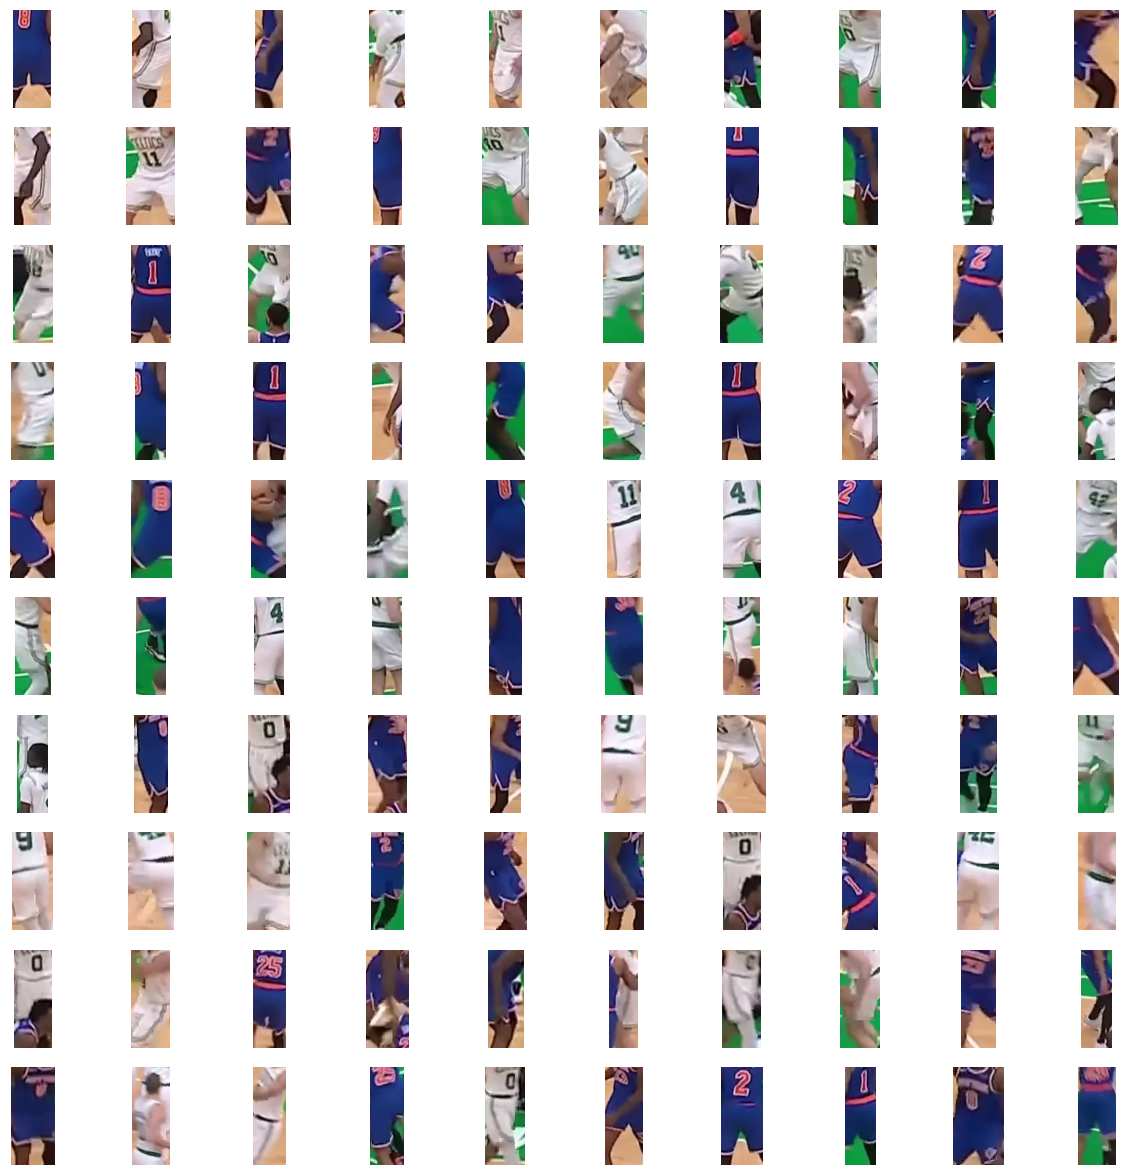

In [33]:
sv.plot_images_grid(
    images=crops[:100],
    grid_size=(10, 10),   # 10 rows × 10 columns = 100 images
    size=(15, 15)         # figure size (adjust as you like)
)


In [34]:
PLAYER_CLS = 0
BALL_CLS   = 1
HOOP_CLS   = 2


In [35]:
def shrink_box_xyxy(box, factor, H, W):
    """
    Shrink an [x1, y1, x2, y2] box around its center by `factor`.
    Clamps to image size (H, W).
    """
    x1, y1, x2, y2 = box
    cx = 0.5 * (x1 + x2)
    cy = 0.5 * (y1 + y2)
    w = (x2 - x1) * factor
    h = (y2 - y1) * factor

    new_x1 = int(max(0, cx - w / 2))
    new_y1 = int(max(0, cy - h / 2))
    new_x2 = int(min(W - 1, cx + w / 2))
    new_y2 = int(min(H - 1, cy + h / 2))
    return new_x1, new_y1, new_x2, new_y2


In [36]:
BALL_CLS_ID = 0   
HOOP_CLS_ID = 1

# long-shot / recovery settings
BALL_CONF_MAIN = 0.20
BALL_CONF_ROI  = 0.06
IMG_MAIN = 960         
IMG_ROI  = 960
ROI_MARGIN = 300
MAX_LOST_FRAMES = int(2 * fps)  # after this, we give up

last_ball_center = None   # (x,y)
last_hoop_center = None   # (x,y)
lost_frames = 0

def best_box_of_class(res, cls_id):
    best = None
    best_conf = -1.0
    for b in res.boxes:
        if int(b.cls[0]) != cls_id:
            continue
        conf = float(b.conf[0])
        if conf > best_conf:
            x1,y1,x2,y2 = b.xyxy[0].tolist()
            best = (x1,y1,x2,y2,conf)
            best_conf = conf
    return best

def center_xyxy(x1,y1,x2,y2):
    return (0.5*(x1+x2), 0.5*(y1+y2))

def corridor_roi(p1, p2, W, H, margin=300):
    (bx, by), (hx, hy) = p1, p2
    x1 = int(max(0, min(bx, hx) - margin))
    y1 = int(max(0, min(by, hy) - margin))
    x2 = int(min(W, max(bx, hx) + margin))
    y2 = int(min(H, max(by, hy) + margin))
    # avoid tiny ROI
    if (x2 - x1) < 50 or (y2 - y1) < 50:
        return None
    return x1, y1, x2, y2


In [37]:

HISTORY_N = 12          # points to fit with
MAX_PRED_FRAMES = 45    # predict for up to 45 frames (~1.5s at 30fps)

ball_hist = deque(maxlen=HISTORY_N)  # stores (frame_idx, cx, cy)
pred_frames_left = 0

def fit_parabola_predictor(hist):
    """
    Fit x(t)=a1*t+b1 and y(t)=a2*t^2+b2*t+c2 using least squares.
    hist: list of (t, x, y)
    returns: functions pred_x(t), pred_y(t) or None if not enough points
    """
    if len(hist) < 6:
        return None

    t = np.array([h[0] for h in hist], dtype=np.float32)
    x = np.array([h[1] for h in hist], dtype=np.float32)
    y = np.array([h[2] for h in hist], dtype=np.float32)

    # normalize time for stability
    t0 = t[-1]
    tn = t - t0

    # x(t) ~ p1*tn + p0
    A1 = np.stack([tn, np.ones_like(tn)], axis=1)
    px, _, _, _ = np.linalg.lstsq(A1, x, rcond=None)

    # y(t) ~ q2*tn^2 + q1*tn + q0
    A2 = np.stack([tn*tn, tn, np.ones_like(tn)], axis=1)
    py, _, _, _ = np.linalg.lstsq(A2, y, rcond=None)

    def pred_x(t_query):
        tq = (t_query - t0)
        return float(px[0]*tq + px[1])

    def pred_y(t_query):
        tq = (t_query - t0)
        return float(py[0]*tq*tq + py[1]*tq + py[2])

    return pred_x, pred_y

def draw_pred_circle(frame, cx, cy):
    cv2.circle(frame, (int(cx), int(cy)), 10, (0,0,255), 2)  # red predicted

def draw_det_circle(frame, cx, cy):
    cv2.circle(frame, (int(cx), int(cy)), 7, (0,255,255), -1)  # yellow detected


In [38]:
# --- keep previous YOLO ball box ---
last_ball_box = None          # (x1,y1,x2,y2,conf)
last_box_age = 10**9
KEEP_LAST_BOX_FRAMES = int(2 * fps)

# --- brown speed circle ---
BROWN = (19, 69, 139)         # BGR brown-ish
MIN_R, MAX_R = 6, 18
speed_ema = 0.0
SPEED_EMA_ALPHA = 0.25
prev_pred = None              # (x,y)

def draw_last_ball_box(frame, box, age):
    x1, y1, x2, y2, conf = box
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)  # red
    cv2.putText(frame, f"Ball LAST ({age})", (x1, max(15, y1 - 6)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, cv2.LINE_AA)

def draw_red_speed_circle(frame, cx, cy, speed_px_per_frame):
    r = int(np.clip(MIN_R + 0.08 * speed_px_per_frame, MIN_R, MAX_R))

    # filled red circle
    cv2.circle(frame, (int(cx), int(cy)), r, (0, 0, 255), -1)

    # small white highlight so it looks like a moving object
    cv2.circle(
        frame,
        (int(cx) - r // 3, int(cy) - r // 3),
        max(1, r // 4),
        (255, 255, 255),
        -1
    )



In [39]:
from collections import deque

# interpolation buffer
missing_frames = []    
missing_len_max = int(2 * fps)  

last_det = None        # (frame_idx, cx, cy)

def lerp(a, b, t):
    return a + (b - a) * t

def draw_red_ball(frame, cx, cy, r=10):
    cv2.circle(frame, (int(cx), int(cy)), r, (0, 0, 255), -1)  # filled red
    cv2.circle(frame, (int(cx) - r//3, int(cy) - r//3), max(1, r//4), (255,255,255), -1)


In [ ]:
#  Manually mapping the court to the caliberated image



# -----------------------------
# 1) TARGET POINTS ON IMAGE PNG
# -----------------------------
clicked_pts = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        clicked_pts.append([x, y])
        cv2.circle(img, (x, y), 6, (0, 0, 255), -1)
        cv2.putText(img, str(len(clicked_pts)), (x+5, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
        cv2.imshow("frame", img)

img = cv2.imread("calib.png")
cv2.imshow("frame", img)
cv2.setMouseCallback("frame", click_event)

while True:
    if cv2.waitKey(1) & 0xFF == 27 or len(clicked_pts) == 6:
        break

cv2.destroyAllWindows()
src_pts = np.array(clicked_pts, dtype=np.float32)


# -----------------------------
# 2) TARGET POINTS ON COURT MAP
# -----------------------------
court_pts = []

def click_court(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        court_pts.append([x, y])
        cv2.circle(court, (x, y), 6, (255, 0, 0), -1)
        cv2.putText(court, str(len(court_pts)), (x+5, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
        cv2.imshow("court", court)

court = cv2.imread("basketball_court.png")
cv2.imshow("court", court)
cv2.setMouseCallback("court", click_court)

while True:
    if cv2.waitKey(1) & 0xFF == 27 or len(court_pts) == 6:
        break

cv2.destroyAllWindows()
dst_pts = np.array(court_pts, dtype=np.float32)



In [41]:
# The points below are extracted externally as GUI support was not available on the University machines
src_pts = np.array([
    [548, 663],
    [1399, 752],
    [1121, 734],
    [182, 775],
    [457, 549],
    [688, 357]
], dtype=np.float32)

dst_pts = np.array([
    [34, 159],
    [163, 160],
    [123, 161],
    [1, 210],
    [1, 108],
    [2, 20]
], dtype=np.float32)


H_homo, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)


def map_point(x, y, H_homo):
    pt = np.array([[[x, y]]], dtype=np.float32)
    mapped = cv2.perspectiveTransform(pt, H_homo)
    return int(mapped[0][0][0]), int(mapped[0][0][1])

mapped_pts = []
for (x, y) in src_pts:
    mx, my = map_point(x, y, H_homo)
    mapped_pts.append([mx, my])

mapped_pts = np.array(mapped_pts, dtype=np.float32)
    
def reprojection_error(src_pts, dst_pts, H_homo):
    """
    Computes mean and per-point reprojection error in pixels.
    """
    src_pts = src_pts.reshape(-1, 1, 2).astype(np.float32)
    dst_pts = dst_pts.reshape(-1, 1, 2).astype(np.float32)

    projected = cv2.perspectiveTransform(src_pts, H_homo)

    errors = np.linalg.norm(projected - dst_pts, axis=2).flatten()

    return errors, errors.mean(), errors.max()


errors, mean_err, max_err = reprojection_error(src_pts, dst_pts, H_homo)

print("Reprojection error per point (pixels):")
for i, e in enumerate(errors):
    print(f" Point {i+1}: {e:.2f}px")

print(f"\nMean reprojection error: {mean_err:.2f}px")
print(f"Max reprojection error:  {max_err:.2f}px")


Reprojection error per point (pixels):
 Point 1: 0.39px
 Point 2: 1.16px
 Point 3: 1.65px
 Point 4: 0.10px
 Point 5: 10.32px
 Point 6: 0.01px

Mean reprojection error: 2.27px
Max reprojection error:  10.32px


In [42]:
# initialising BallPossessionTracker

possession_tracker = BallPossessionTracker(overlap_thresh=0.6, cooldown_frames= 5)
scores = {0: 0, 1: 0}

In [44]:

TEAM_SHRINK_FACTOR = 0.4
frame_idx = 0

print("Homography H shape:", H_homo.shape)
print(H_homo)

fps = cap.get(cv2.CAP_PROP_FPS)
if fps <= 0: fps = 30

# read one frame to set writer size
ret, frame = cap.read()
if not ret:
    raise RuntimeError("Cannot read video")
Hf, Wf = frame.shape[:2]
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

combined_h = Hf + Hf // 2
combined_w = Wf

out = cv2.VideoWriter("tracked_with_court.mp4",
                      cv2.VideoWriter_fourcc(*"mp4v"),
                      fps, (combined_w, combined_h))

# init
last_ball_box = None
last_box_age = 10**9
last_det = None
missing_frames = []
missing_len_max = 15
KEEP_LAST_BOX_FRAMES = 10


court_template = cv2.imread("basketball_court.png")



while True:
    
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1

    Hf, Wf = frame.shape[:2]
    frame_vis = frame.copy()
    court_vis = court_template.copy()

    # ----------------------------
    # YOLO DETECTIONS
    # ----------------------------
    res_players = model_players(frame, verbose=False)[0]
    res_ballhoop = model_ball_hoop(frame, verbose=False)[0]

    detections = []

    # --- Players ---
    for box in res_players.boxes:
        cls = int(box.cls[0])
        if cls == 0:  # Player class
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            w, h = x2 - x1, y2 - y1
            conf = float(box.conf[0])
            detections.append([[x1, y1, w, h], conf, PLAYER_CLS])

    # --- Ball + Hoop (BEST ONLY) ---
    best_ball = best_box_of_class(res_ballhoop, BALL_CLS_ID)
    best_hoop = best_box_of_class(res_ballhoop, HOOP_CLS_ID)

    ball_detected_this_frame = False
    ball_cx = ball_cy = None
    ball_box_xyxy = None

    if best_ball is not None:
        x1, y1, x2, y2, conf = best_ball
        ball_box_xyxy = (x1, y1, x2, y2)
        detections.append([[x1, y1, x2 - x1, y2 - y1], float(conf), BALL_CLS])
        ball_cx, ball_cy = center_xyxy(x1, y1, x2, y2)
        ball_detected_this_frame = True

        # NEW: store last YOLO ball box
        last_ball_box = best_ball
        last_box_age = 0
    else:
        last_box_age += 1
    


    if best_hoop is not None:
        x1, y1, x2, y2, conf = best_hoop
        detections.append([[x1, y1, x2 - x1, y2 - y1], float(conf), HOOP_CLS])

    # ----------------------------
    # TRACKING
    # ----------------------------
    tracks = tracker.update_tracks(detections, frame=frame)
    confirmed_tracks = [t for t in tracks if t.is_confirmed() and t.time_since_update == 0]


    # ----------------------------
    # COLLECT PLAYER BOXES (for possession)
    # ----------------------------
    player_boxes = {}

    for t in confirmed_tracks:
        if getattr(t, "det_class", None) != PLAYER_CLS:
            continue

        x1, y1, x2, y2 = map(int, t.to_ltrb())
        player_boxes[t.track_id] = (x1, y1, x2, y2)



    # ----------------------------
    # TEAM ASSIGNMENT (EVERY FRAME)
    # ----------------------------
    crops_for_assign = []
    track_ids_for_assign = []

    for t in confirmed_tracks:
        if getattr(t, "det_class", None) != PLAYER_CLS:
            continue

        tid = t.track_id
        x1, y1, x2, y2 = t.to_ltrb()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        x1s, y1s, x2s, y2s = shrink_box_xyxy((x1, y1, x2, y2), TEAM_SHRINK_FACTOR, Hf, Wf)

        crop = frame[y1s:y2s, x1s:x2s]
        if crop.size == 0:
            continue

        crops_for_assign.append(crop)
        track_ids_for_assign.append(tid)

    track_team = {}
    if len(crops_for_assign) > 0:
        team_preds = tc.assign_teams_to_crops(crops_for_assign, state)
        for tid, team_id in zip(track_ids_for_assign, team_preds):
            track_team[tid] = int(team_id)
    

    # ----------------------------
    # BALL POSSESSION UPDATE
    # ----------------------------
    current_possession = possession_tracker.update(
        ball_box=ball_box_xyxy,
        player_boxes=player_boxes,
        track_team=track_team,
        frame_idx=frame_idx
    )

    

    # ============================
    # COLLECT PLAYER POINTS
    # ============================
    player_pts = []
    player_ids = []

    for t in confirmed_tracks:
        if getattr(t, "det_class", None) != PLAYER_CLS:
            continue

        x1, y1, x2, y2 = t.to_ltrb()
        cx, cy = cm.player_ground_point_xyxy(x1, y1, x2, y2)
        player_pts.append([cx, cy])
        player_ids.append(t.track_id)


    if len(player_pts) > 0:
        player_pts = np.array(player_pts, dtype=np.float32)
        mapped = cm.map_points_xy(H_homo, player_pts)

        for (x, y), tid in zip(mapped, player_ids):
            team_id = track_team.get(tid, -1)

            if team_id == 0:
                color = (0, 0, 255)      # Team 0 → Red
            elif team_id == 1:
                color = (255, 0, 0)      # Team 1 → Blue
            else:
                color = (128, 128, 128)  # Unknown

            cv2.circle(court_vis, (int(x), int(y)), 6, color, -1)




    

    # ----------------------------
    # DRAWING (boxes)
    # ----------------------------
    for t in confirmed_tracks:
        tid = t.track_id
        x1, y1, x2, y2 = t.to_ltrb()
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        color = (200, 200, 200)
        label_text = f"ID {tid}"

        if getattr(t, "det_class", None) == PLAYER_CLS:
            team_id = track_team.get(tid, -1)
            if team_id == 0:
                color = (0, 0, 255)
                label_text = f"ID {tid} T0"
            elif team_id == 1:
                color = (255, 0, 0)
                label_text = f"ID {tid} T1"
            else:
                color = (128, 128, 128)

        elif getattr(t, "det_class", None) == BALL_CLS:
            color = (0, 255, 255)
            label_text = "Ball"

        elif getattr(t, "det_class", None) == HOOP_CLS:
            color = (0, 255, 0)
            label_text = "Hoop"

        cv2.rectangle(frame_vis, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame_vis, label_text, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)
        
        
    # ----------------------------
    # DISPLAY BALL POSSESSION (CENTERED)
    # ----------------------------
    h, w = frame_vis.shape[:2]

    if current_possession is None:
        poss_text = "Possession: None"
        poss_color = (200, 200, 200)
    elif current_possession == 0:
        poss_text = "Possession: Team 0"
        poss_color = (0, 0, 255)
    else:
        poss_text = "Possession: Team 1"
        poss_color = (255, 0, 0)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.6
    thickness = 3

    (text_w, text_h), _ = cv2.getTextSize(poss_text, font, font_scale, thickness)
    x = (w - text_w) // 2
    y = 60  # vertical offset from top

    cv2.putText(
        frame_vis,
        poss_text,
        (x, y),
        font,
        font_scale,
        poss_color,
        thickness,
        cv2.LINE_AA
    )

        

    # NEW: keep last YOLO box visible when ball is missing
    if (not ball_detected_this_frame) and (last_ball_box is not None) and (last_box_age <= KEEP_LAST_BOX_FRAMES):
        draw_last_ball_box(frame_vis, last_ball_box, last_box_age)

    # ----------------------------
    # INTERPOLATION-BASED "RED BALL"
    # ----------------------------
    if ball_detected_this_frame:
        # current detection
        cur_det = (frame_idx, float(ball_cx), float(ball_cy))

        if last_det is None:
            # first time we ever see the ball
            last_det = cur_det
            draw_det_circle(frame_vis, ball_cx, ball_cy)
            # out.write(frame_vis)

        else:
            # If we had missing frames buffered, now we can interpolate between last_det and cur_det
            if len(missing_frames) > 0:
                t0, x0, y0 = last_det
                t1, x1, y1 = cur_det
                denom = max(1, (t1 - t0))
                # fill each buffered missing frame with interpolated red ball
                for (f_vis_buf, tb) in missing_frames:
                    alpha = (tb - t0) / denom
                    alpha = max(0.0, min(1.0, alpha))
                    xi = lerp(x0, x1, alpha)
                    yi = lerp(y0, y1, alpha)
                    draw_red_ball(f_vis_buf, xi, yi, r=10)
                    # out.write(f_vis_buf)

                missing_frames.clear()

            # write current frame (with detected marker if you want)
            draw_det_circle(frame_vis, ball_cx, ball_cy)
            # out.write(frame_vis)

            # update last detected
            last_det = cur_det

    else:
        # ball missing -> buffer the frame, don't write yet
        missing_frames.append((frame_vis, frame_idx))

        # safety: if ball is missing too long, flush frames without red ball (or draw last known position)
        if len(missing_frames) > missing_len_max:
            # option A: write them as-is (no ball)
            for (f_vis_buf, tb) in missing_frames:
                # out.write(f_vis_buf)
                None
            missing_frames.clear()
    
    court_resized = cv2.resize(court_vis, (Wf, Hf // 2))
    combined_frame = np.vstack([frame_vis, court_resized])
    out.write(combined_frame)



# If video ends while ball is missing, we can't interpolate -> write buffered frames as-is
for (combined_w, combined_h) in missing_frames:
    out.write(f_vis_buf)
    # cv2.imshow("2D Court", court_vis)

missing_frames.clear()

cap.release()
out.release()
print("Saved output to tracked_with_court.mp4")


Homography H shape: (3, 3)
[[    0.21873     0.26242      -241.6]
 [  -0.058236     0.68579     -178.99]
 [-2.6561e-06  0.00081209           1]]


SigLIP embeddings: 1it [00:00, 25.32it/s]
SigLIP embeddings: 1it [00:00, 28.80it/s]
SigLIP embeddings: 1it [00:00, 27.98it/s]
SigLIP embeddings: 1it [00:00, 28.28it/s]
SigLIP embeddings: 1it [00:00, 25.61it/s]
SigLIP embeddings: 1it [00:00, 25.67it/s]
SigLIP embeddings: 1it [00:00, 25.37it/s]
SigLIP embeddings: 1it [00:00, 28.08it/s]
SigLIP embeddings: 1it [00:00, 25.70it/s]
SigLIP embeddings: 1it [00:00, 28.57it/s]
SigLIP embeddings: 1it [00:00, 28.21it/s]
SigLIP embeddings: 1it [00:00, 27.87it/s]
SigLIP embeddings: 1it [00:00, 28.26it/s]
SigLIP embeddings: 1it [00:00, 25.91it/s]
SigLIP embeddings: 1it [00:00, 25.56it/s]
SigLIP embeddings: 1it [00:00, 28.23it/s]
SigLIP embeddings: 1it [00:00, 28.01it/s]
SigLIP embeddings: 1it [00:00, 28.39it/s]
SigLIP embeddings: 1it [00:00, 28.20it/s]
SigLIP embeddings: 1it [00:00, 25.50it/s]
SigLIP embeddings: 1it [00:00, 28.01it/s]
SigLIP embeddings: 1it [00:00, 32.76it/s]
SigLIP embeddings: 1it [00:00, 31.56it/s]
SigLIP embeddings: 1it [00:00, 28.

Saved output to tracked_with_court.mp4
